<a href="https://colab.research.google.com/github/parhambarazesh/PET575/blob/master/Ex6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

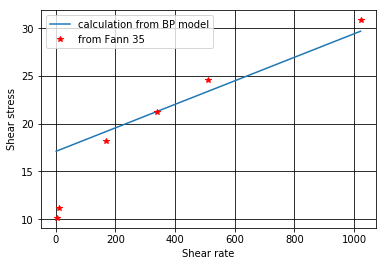

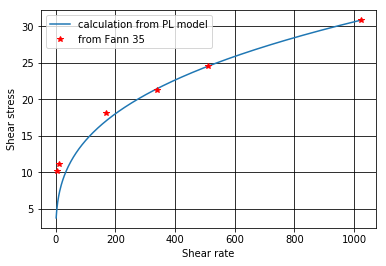

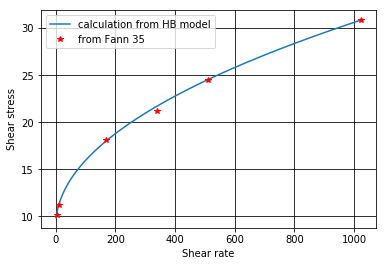

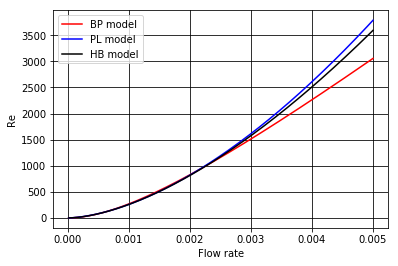

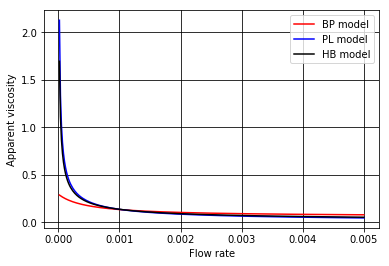

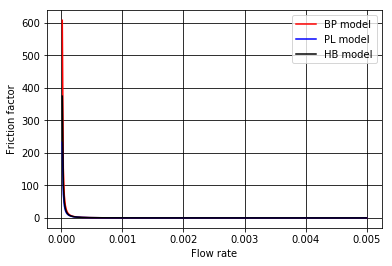

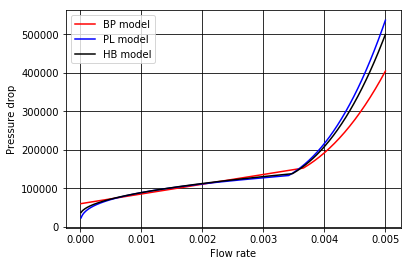

In [0]:
from scipy.optimize import fsolve
import math
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# INPUT
theta=np.array([28.9,23,19.9,17,10.5,9.5])
gamma=np.array([600,300,200,100,6,3])

k1=1.067        #in lbf/100ft^2
k2=1.7023       # s^-1
k3=478.8        # convert lbf/100ft^2 to cPoise

theta_cp=k1*theta
gamma_s=k2*gamma

# Bingham Plastic Model

pv_BPc=(theta[0]-theta[1])
tau0_BPc=theta[1]-pv_BPc

theta_bp=tau0_BPc+pv_BPc*(np.arange(1,601)*k2)/k3 #lbf/100ft^2

tau0_BPc=tau0_BPc*k3*10**-2
pv_BPc=pv_BPc*10**-2

plt.figure(1)
plt.plot(np.arange(1,601)*k2,theta_bp)
plt.plot(gamma_s, theta_cp,'r*')
plt.grid(color='k')
plt.xlabel('Shear rate')
plt.ylabel('Shear stress')
plt.legend(['calculation from BP model','from Fann 35'])

# Power Law Model
n_PLc=np.log((theta_cp[0]/theta_cp[1]))/np.log((gamma_s[0]/gamma_s[1]))
K_PLc=theta_cp[0]/((gamma_s[0])**n_PLc)

theta_PLc=K_PLc*(np.arange(1,601)*k2)**n_PLc #lbf/100ft^2
K_PLc=K_PLc*10**-2*k3

plt.figure(2)
plt.plot(np.arange(1,601)*k2,theta_PLc, gamma_s, theta_cp,'r*')
plt.grid(color='k')
plt.xlabel('Shear rate')
plt.ylabel('Shear stress')
plt.legend(['calculation from PL model','from Fann 35'])

# H-B model
theta_cp_n=[theta_cp[0],theta_cp[1],theta_cp[4]]
gamma_s_n=[gamma_s[0],gamma_s[1],gamma_s[4]]

def equations(p):
    x, y, z = p
    theta_cp_n=[theta_cp[0],theta_cp[1],theta_cp[4]]
    gamma_s_n=[gamma_s[0],gamma_s[1],gamma_s[4]]

    return (theta_cp_n[0]-x-y*(gamma_s_n[0])**z, 
            theta_cp_n[1]-x-y*(gamma_s_n[1])**z,
            theta_cp_n[2]-x-y*(gamma_s_n[2])**z)

tau0_HBc, K_HBc, n_HBc =  fsolve(equations, (0,1,1))

theta_HBc=tau0_HBc+K_HBc*(np.arange(1,601)*k2)**n_HBc#lbf/100ft^2
tau0_HBc=tau0_HBc*k3*10**-2
K_HBc=K_HBc*k3*10**-2

plt.figure(3)
plt.plot(np.arange(1,601)*k2,theta_HBc)
plt.plot(gamma_s, theta_cp,'r*')
plt.grid(color='k')
plt.xlabel('Shear rate')
plt.ylabel('Shear stress')
plt.legend(['calculation from HB model','from Fann 35'])

# Constants in the model
g     = 9.81            #  Gravity [m/s^2]

e     = 0.000           # Absolute roughness in mm for plastic pipe
D     = 24              #  Inner pipe diameter [mm]
D1    = D/1000          #  Inner pipe diameter [m]
A     = 0.25*np.pi*D1**2    #  Pipe crossection [m^2]
L     = 3.5             #  Lengt between horisontal diff sensors [m]
h     = 3.5             #  Lengt between vertical diff sensors [m]

Q     = np.arange(1,301)           #  Flowrate [l/min]
Q1    = Q/60000         #  Flowrate [m^3/s]
V     = Q1/A            #  Average fluid velocity

rho   = 1000            #  Fluid density [kg/m^3]

# Generalized flow index

na_BP=pv_BPc*(8*V/D1)/(tau0_BPc+pv_BPc*(8*V/D1))
na_PL=n_PLc*np.ones(len(na_BP))
na_HB=n_HBc*K_HBc*(8*V/D1)**n_HBc/(tau0_HBc+K_HBc*(8*V/D1)**n_HBc)

# Generalized Renolds number

Re_BP = (rho*V*D1)/(tau0_BPc/8*(D1/V)+pv_BPc*((3*na_BP+1)/(4*na_BP)))   #   Reynold number of BP
Re_PL = (rho*V**(2-n_PLc)*D1**n_PLc)/(K_PLc*((3*na_PL+1)/(4*na_PL))**n_PLc*8**(n_PLc-1))   #   Reynold number of PL
Re_HB = (rho*V**(2-n_HBc)*D1**n_HBc)/(tau0_HBc/8*(D1/V)**n_HBc+K_HBc*((3*na_HB+1)/(4*na_HB))**n_HBc*8**(n_HBc-1))   #   Reynold number of BP

plt.figure(4)
plt.plot(Q1,Re_BP,'r')
plt.plot(Q1,Re_PL,'b')
plt.plot(Q1,Re_HB,'k')
plt.grid(color='k')
plt.xlabel('Flow rate')
plt.ylabel('Re')
plt.legend(['BP model','PL model','HB model'])

# Effecitve inner diameter

Deff_BP=4*na_BP/(3*na_BP+1)*D1
Deff_PL=4*na_PL/(3*na_PL+1)*D1
Deff_HB=4*na_HB/(3*na_HB+1)*D1

# apparent viscosity

vapp_BP=rho*V*Deff_BP/Re_BP
vapp_PL=rho*V*Deff_PL/Re_PL
vapp_HB=rho*V*Deff_HB/Re_HB

plt.figure(5)
plt.plot(Q1,vapp_BP,'r')
plt.plot(Q1,vapp_PL,'b')
plt.plot(Q1,vapp_HB,'k')
plt.grid(color='k')
plt.xlabel('Flow rate')
plt.ylabel('Apparent viscosity')
plt.legend(['BP model','PL model','HB model'])

# Calculate friction factor

f_BP=np.zeros(len(Re_BP))
for i in range(len(Re_BP)):
    if Re_BP[i]<=2000:
        f_BP[i]=64/Re_BP[i]
    elif Re_BP[i]<=4000:
        weight=(Re_BP[i]-2000)/(4000-3000)
        f_BP[i]=64/Re_BP[i]*(1-weight)+weight*(1/(-1.8*np.log10(((e/Deff_BP[i])/3.7)**1.11+6.9/Re_BP[i])))**2
    else:
        f_BP[i]=(1/(-1.8*np.log10(((e/Deff_BP[i])/3.7)**1.11+6.9/Re_BP[i])))**2

f_PL=np.zeros(len(Re_PL))
for i in range(len(Re_PL)):
    if Re_PL[i]<=2000:
        f_PL[i]=64/Re_PL[i]
    elif Re_PL[i]<=4000:
        weight=(Re_PL[i]-2000)/(4000-3000)
        f_PL[i]=64/Re_PL[i]*(1-weight)+weight*(1/(-1.8*np.log10(((e/Deff_PL[i])/3.7)**1.11+6.9/Re_PL[i])))**2
    else:
        f_PL[i]=(1/(-1.8*np/log10(((e/Deff_PL[i])/3.7)**1.11+6.9/Re_PL[i])))**2

f_HB=np.zeros(len(Re_HB))

for i in range(len(Re_HB)):
    if Re_HB[i]<=2000:
        f_HB[i]=64/Re_HB[i]
    elif Re_HB[i]<=4000:
        weight=(Re_HB[i]-2000)/(4000-3000);
        f_HB[i]=64/Re_HB[i]*(1-weight)+weight*(1/(-1.8*np.log10(((e/Deff_HB[i])/3.7)**1.11+6.9/Re_HB[i])))**2
    else:
        f_HB[i]=(1/(-1.8*np.log10(((e/Deff_HB[i])/3.7)**1.11+6.9/Re_HB[i])))**2
        
plt.figure(6)
plt.plot(Q1,f_BP,'r')
plt.plot(Q1,f_PL,'b')
plt.plot(Q1,f_HB,'k')
plt.grid(color='k')
plt.xlabel('Flow rate')
plt.ylabel('Friction factor')
plt.legend(['BP model','PL model','HB model'])

# Calculate pressure loss

Dp_BP=f_BP*L*rho*(V)**2/2/D1
Dp_PL=f_PL*L*rho*(V)**2/2/D1
Dp_HB=f_HB*L*rho*(V)**2/2/D1

plt.figure(7)
plt.plot(Q1,Dp_BP,'r')
plt.plot(Q1,Dp_PL,'b')
plt.plot(Q1,Dp_HB,'k')
plt.grid(color='k')
plt.xlabel('Flow rate')
plt.ylabel('Pressure drop')
plt.legend(['BP model','PL model','HB model'])


